Loading Children's Data (Fever Prevalence - Integer Mode)...


/var/folders/jr/x6fm65cx0hlblk09pm9kft3h0000gn/T/ipykernel_1758/2467471691.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['w'] = df['v005'] / 1000000.0



--- Final Results (No Decimals) ---
                   Val
Location              
Rwamagana            9
Nyagatare           24
Gatsibo              8
Kayonza             21
Kirehe              22
Ngoma                7
Bugesera            24
East Province       17
Rwanda (National)   18
✅ Analysis Complete. JSON: eastern_fever_prevalence_final.json, Plot: Fever_Prevalence_Final.png


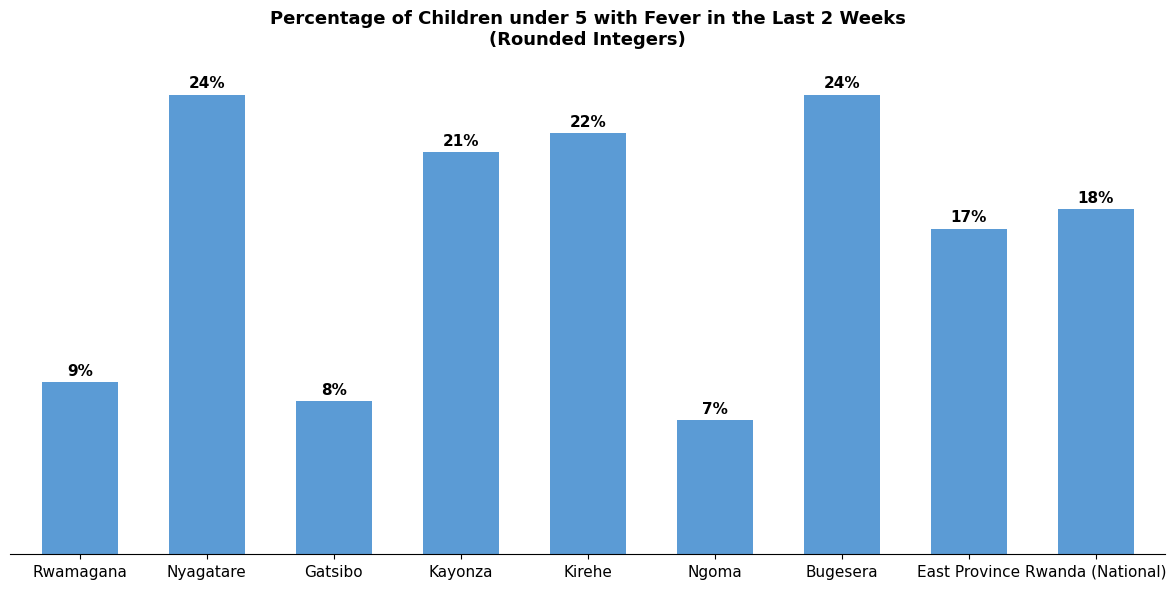

In [3]:
#!/usr/bin/env python3
# dhs_fever_prevalence_integer.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import math

# ------------------------------------------------------------------
# 1. SETTINGS
# ------------------------------------------------------------------
DATA_DIR = "data"
FILE_PATH = os.path.join(DATA_DIR, "RWKR81FL.DTA")

DIST_MAP = {
    51: 'Rwamagana', 52: 'Nyagatare', 53: 'Gatsibo',
    54: 'Kayonza', 55: 'Kirehe', 56: 'Ngoma', 57: 'Bugesera'
}  

# ------------------------------------------------------------------
# 2. CALCULATION HELPERS
# ------------------------------------------------------------------
def standard_round(n):
    """Rounds 0.5 up to next integer, below 0.5 down."""
    return int(math.floor(n + 0.5))

def get_fever_stats(df):
    """Calculates weighted % of fever as rounded integer."""
    if df.empty or 'w' not in df.columns or df['w'].sum() == 0:
        return 0
    # h22 == 1 means fever present
    raw_pct = np.average(df['h22'] == 1, weights=df['w']) * 100
    return standard_round(raw_pct)

# ------------------------------------------------------------------
# 3. ANALYSIS PIPELINE
# ------------------------------------------------------------------
if __name__ == "__main__":
    if not os.path.exists(FILE_PATH):
        print(f"❌ Error: {FILE_PATH} not found."); exit()

    print("Loading Children's Data (Fever Prevalence - Integer Mode)...")
    df = pd.read_stata(FILE_PATH, convert_categoricals=False)
    df.columns = df.columns.str.lower()

    # --- FORCED NUMERIC ---
    cols = ['v005', 'v024', 'h22', 'v008', 'b3']
    for col in cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

    # Weights
    df['w'] = df['v005'] / 1000000.0

    # Filter: Children < 5
    df = df[(df['v008'] - df['b3']) < 60].copy()

    # --- AGGREGATION ---
    results = {}
    dist_col = next((c for c in ['sdistrict', 'sdstr'] if c in df.columns), 'v001')
    
    # East Province (Region 5)
    df_east = df[df['v024'] == 5].copy()
    
    for code, name in DIST_MAP.items():
        subset = df_east[df_east[dist_col] == code]
        results[name] = get_fever_stats(subset)

    results["East Province"] = get_fever_stats(df_east)
    results["Rwanda (National)"] = get_fever_stats(df)

    final_df = pd.DataFrame(list(results.items()), columns=["Location", "Val"]).set_index("Location")
    print("\n--- Final Results (No Decimals) ---")
    print(final_df)

    # --- JSON OUTPUT ---
    json_name = "eastern_fever_prevalence_final.json"
    with open(json_name, "w") as f:
        json.dump(final_df["Val"].to_dict(), f, indent=4)

    # --- PLOTTING ---
    colors = ["#5B9BD5"] * 7 + ["#00B050", "#ED7D31"]
    ax = final_df.plot(kind="bar", color=colors, figsize=(12, 6), width=0.6, legend=False)
    
    plt.title("Percentage of Children under 5 with Fever in the Last 2 Weeks\n(Rounded Integers)", 
              fontsize=13, fontweight="bold", pad=20)
    
    plt.xticks(rotation=0, fontsize=11)
    plt.xlabel("")
    ax.yaxis.set_visible(False)
    for s in ["top", "right", "left"]: 
        ax.spines[s].set_visible(False)
    
    # Bar Labels (using %d for integer format)
    for c in ax.containers:
        ax.bar_label(c, fmt='%d%%', padding=3, fontsize=11, fontweight="bold")
    
    plt.tight_layout()
    plt.savefig("Fever_Prevalence.png", dpi=300)
    print(f"✅ Analysis Complete. JSON: {json_name}, Plot: Fever_Prevalence_Final.png")